In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sec-edgar-company-facts-september2023/companyfacts.csv
/kaggle/input/sec-edgar-company-facts-september2023/line_item_counts.csv


In [2]:
!pip install pandas numpy transformers matplotlib seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import T5ForConditionalGeneration, T5Tokenizer


In [3]:
import os
import random
import numpy as np
import torch

# Set environment variable for Python hash seed
os.environ['PYTHONHASHSEED'] = str(42)

# Set Python built-in random seed
random.seed(42)

# Set NumPy random seed
np.random.seed(42)

# Set PyTorch random seed and ensure deterministic behavior
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set TensorFlow random seed if using TensorFlow/Keras
try:
    import tensorflow as tf
    tf.random.set_seed(42)
except ImportError:
    pass

print("All seeds set for reproducibility.")


All seeds set for reproducibility.


In [4]:
company=pd.read_csv("/kaggle/input/sec-edgar-company-facts-september2023/companyfacts.csv",nrows=2000)
line_count=pd.read_csv("/kaggle/input/sec-edgar-company-facts-september2023/line_item_counts.csv",nrows=2000)

## Exploratory data analysis

In [5]:
company.head()

,Unnamed: 0,cik,entityName,companyFact,end,val,accn,fy,fp,form,filed,units
0,0,1750,AAR CORP,AccountsPayableCurrent,2010-05-31,114906000,0001104659-10-049632,2011,Q1,10-Q,2010-09-23,USD
1,1,1750,AAR CORP,AccountsPayableCurrent,2010-05-31,114906000,0001104659-10-063683,2011,Q2,10-Q,2010-12-21,USD
2,2,1750,AAR CORP,AccountsPayableCurrent,2010-05-31,114906000,0001104659-11-015691,2011,Q3,10-Q,2011-03-22,USD
3,3,1750,AAR CORP,AccountsPayableCurrent,2010-05-31,114906000,0001047469-11-006302,2011,FY,10-K,2011-07-13,USD
4,4,1750,AAR CORP,AccountsPayableCurrent,2010-08-31,130112000,0001104659-10-049632,2011,Q1,10-Q,2010-09-23,USD


In [6]:
line_count.head()

,Unnamed: 0,line_item,count,description
0,0,AccountsPayableCurrent,9403.0,Carrying value as of the balance sheet date of...
1,1,AccountsReceivableNetCurrent,8211.0,"Amount, after allowance for credit loss, of ri..."
2,2,AccruedLiabilitiesCurrent,7549.0,Carrying value as of the balance sheet date of...
3,3,AccruedLiabilitiesCurrentAndNoncurrent,1307.0,Carrying value as of the balance sheet date of...
4,4,AccumulatedDepreciationDepletionAndAmortizatio...,9889.0,"Amount of accumulated depreciation, depletion ..."


In [7]:

merged_df = pd.merge(company, line_count, left_on='companyFact', right_on='line_item', how='left')

print("Merged DataFrame:")
print(merged_df.head())


Merged DataFrame:
   Unnamed: 0_x   cik entityName             companyFact         end  \
0             0  1750   AAR CORP  AccountsPayableCurrent  2010-05-31   
1             1  1750   AAR CORP  AccountsPayableCurrent  2010-05-31   
2             2  1750   AAR CORP  AccountsPayableCurrent  2010-05-31   
3             3  1750   AAR CORP  AccountsPayableCurrent  2010-05-31   
4             4  1750   AAR CORP  AccountsPayableCurrent  2010-08-31   

         val                  accn    fy  fp  form       filed units  \
0  114906000  0001104659-10-049632  2011  Q1  10-Q  2010-09-23   USD   
1  114906000  0001104659-10-063683  2011  Q2  10-Q  2010-12-21   USD   
2  114906000  0001104659-11-015691  2011  Q3  10-Q  2011-03-22   USD   
3  114906000  0001047469-11-006302  2011  FY  10-K  2011-07-13   USD   
4  130112000  0001104659-10-049632  2011  Q1  10-Q  2010-09-23   USD   

   Unnamed: 0_y               line_item   count  \
0             0  AccountsPayableCurrent  9403.0   
1             

In [8]:
# Assume 'filed' or 'end' is the date you want to use; we'll use 'filed' here.
# Convert 'filed' to datetime if not already done.
merged_df['filed'] = pd.to_datetime(merged_df['filed'], errors='coerce')

# Filter for the key metric, e.g., AccountsPayableCurrent, for a specific company
metric_df = merged_df[(merged_df['companyFact'] == 'AccountsPayableCurrent') &
                      (merged_df['entityName'] == 'AAR CORP')]

# Set 'filed' as the index and sort by date
metric_df.set_index('filed', inplace=True)
metric_df.sort_index(inplace=True)

# Aggregate by day. If there are multiple filings in a day, you could take the mean.
daily_series = metric_df['val'].resample('D').mean()

# Fill missing days by forward filling (or choose another method)
daily_series_filled = daily_series.ffill()

# Inspect the daily series
print(daily_series_filled.head(20))



filed
2010-09-23    122509000.0
2010-09-24    122509000.0
2010-09-25    122509000.0
2010-09-26    122509000.0
2010-09-27    122509000.0
2010-09-28    122509000.0
2010-09-29    122509000.0
2010-09-30    122509000.0
2010-10-01    122509000.0
2010-10-02    122509000.0
2010-10-03    122509000.0
2010-10-04    122509000.0
2010-10-05    122509000.0
2010-10-06    122509000.0
2010-10-07    122509000.0
2010-10-08    122509000.0
2010-10-09    122509000.0
2010-10-10    122509000.0
2010-10-11    122509000.0
2010-10-12    122509000.0
Freq: D, Name: val, dtype: float64


<ipython-input-8-96fc642488e3>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metric_df.sort_index(inplace=True)


## Aggregating data on daily basis taking "AccountsPayableCurrent" as the Key Metric

In [9]:
# Filter for key metric and specific company (e.g., AAR CORP)
daily_df = merged_df[(merged_df['companyFact'] == 'AccountsPayableCurrent') &
                     (merged_df['entityName'] == 'AAR CORP')].copy()

# Convert 'filed' column to datetime if not already done and set it as the index
daily_df['filed'] = pd.to_datetime(daily_df['filed'], errors='coerce')
daily_df.set_index('filed', inplace=True)
daily_df.sort_index(inplace=True)

# Resample by day: If multiple filings exist on one day, take their mean
daily_series = daily_df['val'].resample('D').mean()

# Forward-fill missing days (you might also consider interpolation)
daily_series_filled = daily_series.ffill()

# Optionally, create a new aggregated DataFrame for daily data
agg_daily_df = daily_series_filled.reset_index()
agg_daily_df.columns = ['date', 'AccountsPayableCurrent']

# Display the daily aggregated data
print(agg_daily_df.head(20))
print(agg_daily_df)

         date  AccountsPayableCurrent
0  2010-09-23             122509000.0
1  2010-09-24             122509000.0
2  2010-09-25             122509000.0
3  2010-09-26             122509000.0
4  2010-09-27             122509000.0
5  2010-09-28             122509000.0
6  2010-09-29             122509000.0
7  2010-09-30             122509000.0
8  2010-10-01             122509000.0
9  2010-10-02             122509000.0
10 2010-10-03             122509000.0
11 2010-10-04             122509000.0
12 2010-10-05             122509000.0
13 2010-10-06             122509000.0
14 2010-10-07             122509000.0
15 2010-10-08             122509000.0
16 2010-10-09             122509000.0
17 2010-10-10             122509000.0
18 2010-10-11             122509000.0
19 2010-10-12             122509000.0
           date  AccountsPayableCurrent
0    2010-09-23             122509000.0
1    2010-09-24             122509000.0
2    2010-09-25             122509000.0
3    2010-09-26             122509000.0
4 

In [10]:
print("Missing values in merged dataframe:")
print(merged_df.isnull().sum())


Missing values in merged dataframe:
Unnamed: 0_x    0
cik             0
entityName      0
companyFact     0
end             0
val             0
accn            0
fy              0
fp              0
form            0
filed           0
units           0
Unnamed: 0_y    0
line_item       0
count           0
description     0
dtype: int64


In [11]:
print("Summary statistics for 'val':")
print(merged_df['val'].describe())


Summary statistics for 'val':
count    2.000000e+03
mean     2.372372e+08
std      4.491262e+08
min     -3.645000e+08
25%      1.207504e+06
50%      4.455000e+07
75%      2.384660e+08
max      2.227700e+09
Name: val, dtype: float64


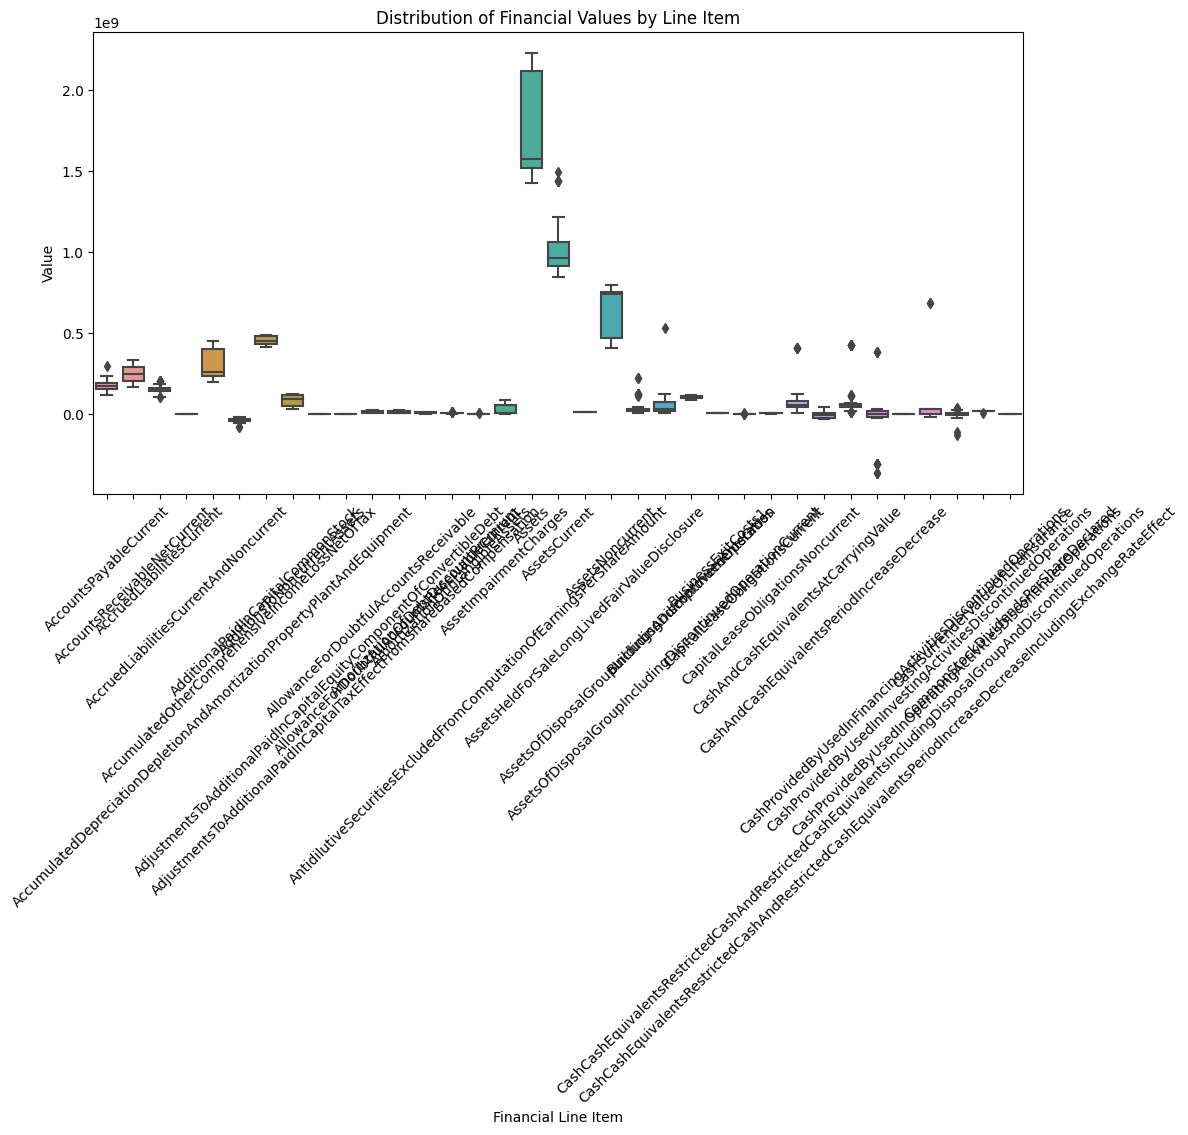

In [12]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='companyFact', y='val', data=merged_df)
plt.xticks(rotation=45)
plt.title("Distribution of Financial Values by Line Item")
plt.xlabel("Financial Line Item")
plt.ylabel("Value")
plt.show()


In [13]:

key_metric = "AccountsPayableCurrent"


metric_df = merged_df[merged_df['companyFact'] == key_metric]


print("Filtered data for key metric (AccountsPayableCurrent):")
print(metric_df.head())


Filtered data for key metric (AccountsPayableCurrent):
   Unnamed: 0_x   cik entityName             companyFact         end  \
0             0  1750   AAR CORP  AccountsPayableCurrent  2010-05-31   
1             1  1750   AAR CORP  AccountsPayableCurrent  2010-05-31   
2             2  1750   AAR CORP  AccountsPayableCurrent  2010-05-31   
3             3  1750   AAR CORP  AccountsPayableCurrent  2010-05-31   
4             4  1750   AAR CORP  AccountsPayableCurrent  2010-08-31   

         val                  accn    fy  fp  form      filed units  \
0  114906000  0001104659-10-049632  2011  Q1  10-Q 2010-09-23   USD   
1  114906000  0001104659-10-063683  2011  Q2  10-Q 2010-12-21   USD   
2  114906000  0001104659-11-015691  2011  Q3  10-Q 2011-03-22   USD   
3  114906000  0001047469-11-006302  2011  FY  10-K 2011-07-13   USD   
4  130112000  0001104659-10-049632  2011  Q1  10-Q 2010-09-23   USD   

   Unnamed: 0_y               line_item   count  \
0             0  AccountsPayableCu

In [14]:
# Group by 'entityName' and 'year' and calculate the average value of the key metric
#agg_df = metric_df.groupby(['entityName', 'year'])['val'].mean().reset_index()

# Rename the aggregated column for clarity
#agg_df.rename(columns={'val': 'AccountsPayableCurrent'}, inplace=True)

# Display the aggregated data
print("Aggregated Data for AccountsPayableCurrent:")
print(agg_daily_df.head())


Aggregated Data for AccountsPayableCurrent:
        date  AccountsPayableCurrent
0 2010-09-23             122509000.0
1 2010-09-24             122509000.0
2 2010-09-25             122509000.0
3 2010-09-26             122509000.0
4 2010-09-27             122509000.0


## doing K means clustering

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

# Extract the feature for clustering
X = agg_daily_df[['AccountsPayableCurrent']].values

# Standardize the feature values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Choose the number of clusters, e.g., k=3
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
agg_daily_df['cluster'] = kmeans.fit_predict(X_scaled)

# Display the updated aggregated dataframe with cluster labels
print("Aggregated Data with Cluster Labels:")
print(agg_daily_df.head())


Aggregated Data with Cluster Labels:
        date  AccountsPayableCurrent  cluster
0 2010-09-23             122509000.0        1
1 2010-09-24             122509000.0        1
2 2010-09-25             122509000.0        1
3 2010-09-26             122509000.0        1
4 2010-09-27             122509000.0        1


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## Plot of the clusters

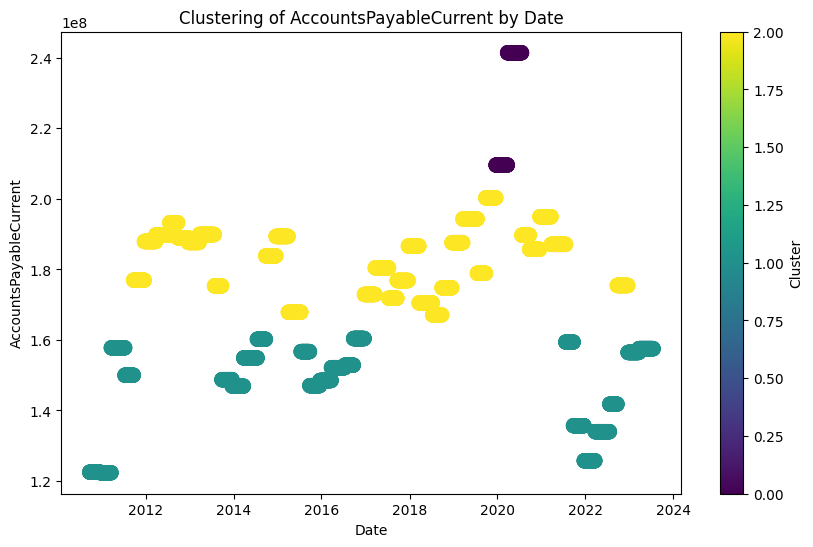

In [16]:
plt.figure(figsize=(10, 6))
plt.scatter(agg_daily_df['date'], agg_daily_df['AccountsPayableCurrent'], c=agg_daily_df['cluster'], cmap='viridis', s=100)
plt.xlabel('Date')
plt.ylabel('AccountsPayableCurrent')
plt.title('Clustering of AccountsPayableCurrent by Date')
plt.colorbar(label='Cluster')
plt.show()


In [17]:
print(agg_daily_df.head())

        date  AccountsPayableCurrent  cluster
0 2010-09-23             122509000.0        1
1 2010-09-24             122509000.0        1
2 2010-09-25             122509000.0        1
3 2010-09-26             122509000.0        1
4 2010-09-27             122509000.0        1


## Creating an anomaly flag based on a rule:-the 90th %ile of distances among the clusters

In [18]:
# First, ensure that 'date' is in datetime format and create a 'year' column
agg_daily_df['date'] = pd.to_datetime(agg_daily_df['date'])
agg_daily_df['year'] = agg_daily_df['date'].dt.year

# Compute the distances from each point to each cluster center using the scaled features
distances = kmeans.transform(X_scaled)

# For each data point, extract the distance to its assigned cluster center
agg_daily_df['distance'] = [distances[i, cluster] for i, cluster in enumerate(agg_daily_df['cluster'])]

# Define an anomaly threshold,  the 90th percentile of distances
threshold = np.percentile(agg_daily_df['distance'], 90)
agg_daily_df['anomaly'] = agg_daily_df['distance'] > threshold

# Display the daily aggregated data with the distance, year, and anomaly flag
print("Data with distance and anomaly flag:")
print(agg_daily_df[['date', 'year', 'AccountsPayableCurrent', 'cluster', 'distance', 'anomaly']])


Data with distance and anomaly flag:
           date  year  AccountsPayableCurrent  cluster  distance  anomaly
0    2010-09-23  2010             122509000.0        1  1.026015     True
1    2010-09-24  2010             122509000.0        1  1.026015     True
2    2010-09-25  2010             122509000.0        1  1.026015     True
3    2010-09-26  2010             122509000.0        1  1.026015     True
4    2010-09-27  2010             122509000.0        1  1.026015     True
...         ...   ...                     ...      ...       ...      ...
4677 2023-07-14  2023             157550000.0        1  0.439019    False
4678 2023-07-15  2023             157550000.0        1  0.439019    False
4679 2023-07-16  2023             157550000.0        1  0.439019    False
4680 2023-07-17  2023             157550000.0        1  0.439019    False
4681 2023-07-18  2023             157450000.0        1  0.434838    False

[4682 rows x 6 columns]


## Creating an explanation for Anomaly

In [19]:
def generate_explanation(row, cluster_mean):
    return (f"Anomaly detected: {row['AccountsPayableCurrent']:.2f} "
            f"deviates significantly from the cluster average of {cluster_mean:.2f}.")

# Create a new column for anomaly explanations in the daily aggregated DataFrame
agg_daily_df['anomaly_explanation'] = None

# For each cluster, calculate the cluster average and generate explanations for anomalies
for cluster in agg_daily_df['cluster'].unique():
    cluster_avg = agg_daily_df.loc[agg_daily_df['cluster'] == cluster, 'AccountsPayableCurrent'].mean()
    for idx, row in agg_daily_df[agg_daily_df['cluster'] == cluster].iterrows():
        if row['anomaly']:
            agg_daily_df.loc[idx, 'anomaly_explanation'] = generate_explanation(row, cluster_avg)

print("Data with Anomaly Explanations:")
print(agg_daily_df[['date', 'year', 'AccountsPayableCurrent', 'cluster', 'distance', 'anomaly', 'anomaly_explanation']].head())


Data with Anomaly Explanations:
        date  year  AccountsPayableCurrent  cluster  distance  anomaly  \
0 2010-09-23  2010             122509000.0        1  1.026015     True   
1 2010-09-24  2010             122509000.0        1  1.026015     True   
2 2010-09-25  2010             122509000.0        1  1.026015     True   
3 2010-09-26  2010             122509000.0        1  1.026015     True   
4 2010-09-27  2010             122509000.0        1  1.026015     True   

                                 anomaly_explanation  
0  Anomaly detected: 122509000.00 deviates signif...  
1  Anomaly detected: 122509000.00 deviates signif...  
2  Anomaly detected: 122509000.00 deviates signif...  
3  Anomaly detected: 122509000.00 deviates signif...  
4  Anomaly detected: 122509000.00 deviates signif...  


## creating an interactive widget for visualising the anomaly on each day

In [20]:
import ipywidgets as widgets
from IPython.display import display, Markdown

# Function to get available dates for a given year
def get_date_options(year):
    # Filter agg_daily_df for the selected year and get unique dates
    dates = agg_daily_df[agg_daily_df['year'] == year]['date'].unique()
    # Sort the dates
    return sorted(dates)

# Create a year dropdown widget using unique years from agg_daily_df
year_widget = widgets.Dropdown(
    options=sorted(agg_daily_df['year'].unique()),
    description='Select Year:',
    style={'description_width': 'initial'}
)

# Create a date dropdown widget with initial options based on the default selected year
date_widget = widgets.Dropdown(
    options=get_date_options(year_widget.value),
    description='Select Date:',
    style={'description_width': 'initial'}
)

# Update the date_widget options when the year_widget value changes
def update_date_options(change):
    date_widget.options = get_date_options(change.new)

year_widget.observe(update_date_options, names='value')

# Define a function that displays details for the selected year and date
def display_dashboard(selected_year, selected_date):
    filtered_data = agg_daily_df[(agg_daily_df['year'] == selected_year) &
                                 (agg_daily_df['date'] == selected_date)]
    if filtered_data.empty:
        display(Markdown("### No data available for the selected date."))
    else:
        for index, row in filtered_data.iterrows():
            display(Markdown(f"### Date: {row['date'].strftime('%Y-%m-%d')} ({row['year']})"))
            display(Markdown(f"**AccountsPayableCurrent:** ${row['AccountsPayableCurrent']:.2f}"))
            display(Markdown(f"**Cluster:** {row['cluster']}"))
            display(Markdown(f"**Distance to Cluster Center:** {row['distance']:.3f}"))
            if row['anomaly']:
                display(Markdown("**:red[Anomaly Detected!]**"))
                display(Markdown(f"*{row['anomaly_explanation']}*"))
            else:
                display(Markdown("No anomaly detected."))
            display(Markdown("---"))

# Create interactive output that uses both dropdowns
ui = widgets.VBox([year_widget, date_widget])
out = widgets.interactive_output(display_dashboard, {'selected_year': year_widget, 'selected_date': date_widget})

# Display the dashboard
display(ui, out)


Output()

## doing forecast on the data using some models

In [21]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt


In [22]:
# Use the daily aggregated data directly as forecast_df
forecast_df = agg_daily_df.copy()

# Rename the 'date' column to 'ds' and 'AccountsPayableCurrent' to 'y'
forecast_df.rename(columns={'date': 'ds', 'AccountsPayableCurrent': 'y'}, inplace=True)

# Ensure 'ds' is a datetime type
forecast_df['ds'] = pd.to_datetime(forecast_df['ds'], errors='coerce')

# Sort the DataFrame by date
forecast_df = forecast_df.sort_values('ds')

print("Data prepared for forecasting:")
print(forecast_df[['ds', 'y']].head())


Data prepared for forecasting:
          ds            y
0 2010-09-23  122509000.0
1 2010-09-24  122509000.0
2 2010-09-25  122509000.0
3 2010-09-26  122509000.0
4 2010-09-27  122509000.0


In [23]:
# Initialize the Prophet model (yearly seasonality is enabled by default)
model = Prophet(yearly_seasonality=True)

# Fit the model on the prepared data
model.fit(forecast_df[['ds', 'y']])


04:18:39 - cmdstanpy - INFO - Chain [1] start processing
04:18:41 - cmdstanpy - INFO - Chain [1] done processing


In [24]:
# Create a future dataframe for the next 5 years at daily frequency.
# Using 5*365 days (you could adjust for leap years if needed)
future = model.make_future_dataframe(periods=5*365, freq='D')

# Generate the forecast
forecast = model.predict(future)

# Display the last few rows of the forecast
print("Forecasted data:")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())


Forecasted data:
             ds          yhat    yhat_lower    yhat_upper
6502 2028-07-12  7.341863e+07 -3.382149e+08  4.799292e+08
6503 2028-07-13  7.300261e+07 -3.401717e+08  4.900465e+08
6504 2028-07-14  7.250679e+07 -3.398055e+08  4.886880e+08
6505 2028-07-15  7.191098e+07 -3.415344e+08  4.875205e+08
6506 2028-07-16  7.128716e+07 -3.415929e+08  4.889806e+08


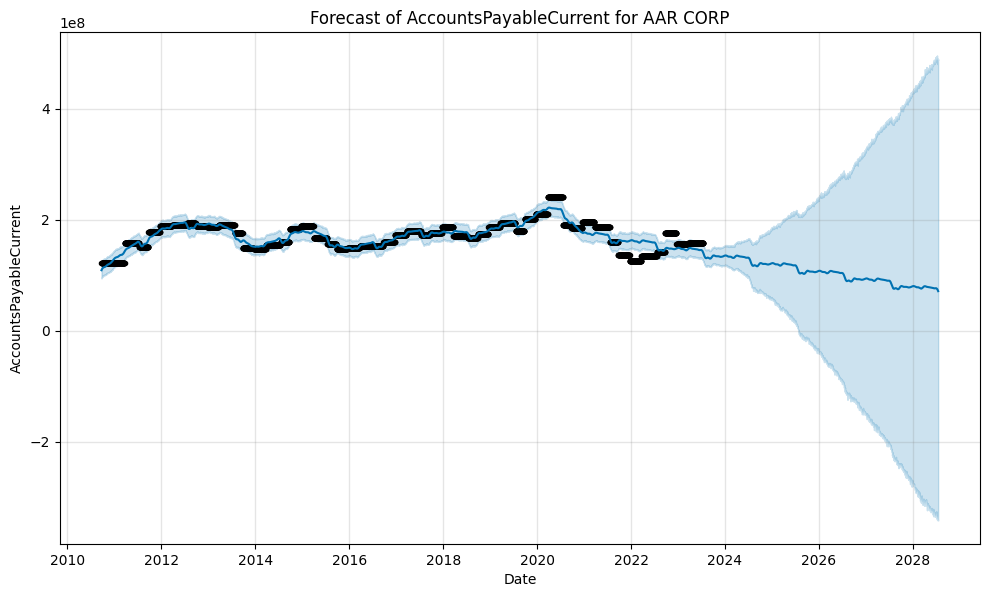

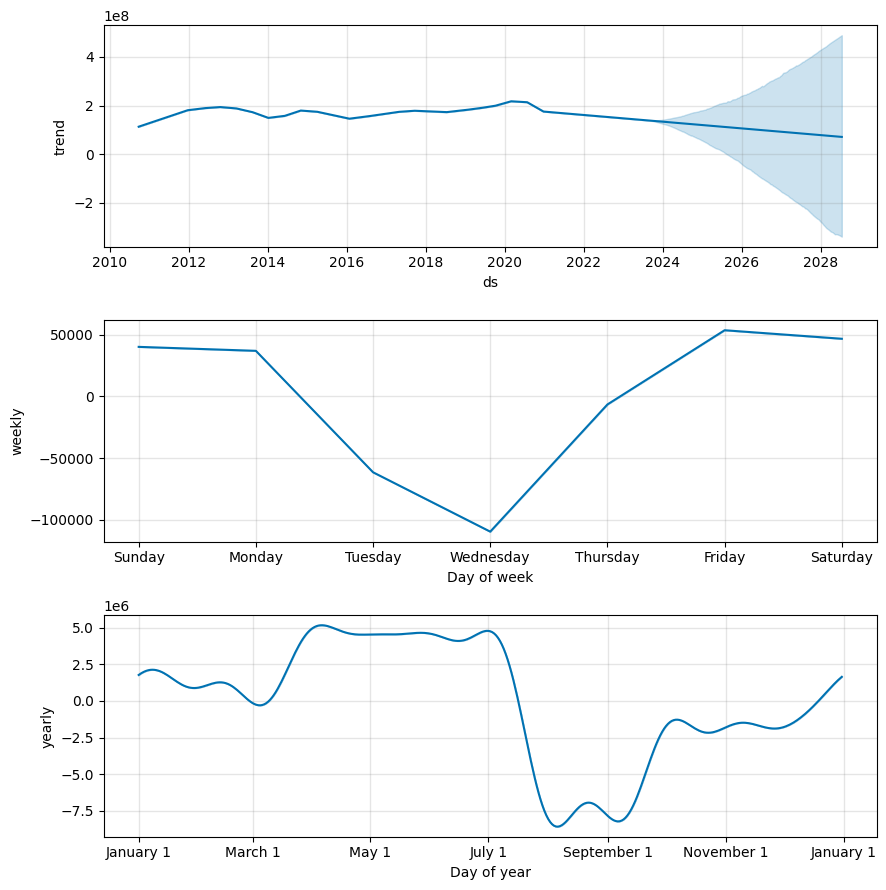

In [25]:
# Plot the forecast
fig1 = model.plot(forecast)
plt.title("Forecast of AccountsPayableCurrent for AAR CORP")
plt.xlabel("Date")
plt.ylabel("AccountsPayableCurrent")
plt.show()

# Optionally, plot the forecast components (trend, seasonality, etc.)
fig2 = model.plot_components(forecast)
plt.show()


In [26]:
from prophet.diagnostics import cross_validation, performance_metrics

df_cv = cross_validation(model, initial='1825 days', period='365 days', horizon='730 days')
df_p = performance_metrics(df_cv)

print("Forecast performance metrics:")
print(df_p.head())


  0%|          | 0/6 [00:00<?, ?it/s]

04:19:17 - cmdstanpy - INFO - Chain [1] start processing
04:19:18 - cmdstanpy - INFO - Chain [1] done processing
04:19:18 - cmdstanpy - INFO - Chain [1] start processing
04:19:20 - cmdstanpy - INFO - Chain [1] done processing
04:19:20 - cmdstanpy - INFO - Chain [1] start processing
04:19:21 - cmdstanpy - INFO - Chain [1] done processing
04:19:21 - cmdstanpy - INFO - Chain [1] start processing
04:19:23 - cmdstanpy - INFO - Chain [1] done processing
04:19:23 - cmdstanpy - INFO - Chain [1] start processing
04:19:25 - cmdstanpy - INFO - Chain [1] done processing
04:19:25 - cmdstanpy - INFO - Chain [1] start processing
04:19:27 - cmdstanpy - INFO - Chain [1] done processing


Forecast performance metrics:
  horizon           mse          rmse           mae      mape     mdape  \
0 73 days  4.641190e+14  2.154342e+07  1.660560e+07  0.097787  0.057874   
1 74 days  4.775396e+14  2.185268e+07  1.684556e+07  0.099374  0.060482   
2 75 days  4.911098e+14  2.216100e+07  1.708860e+07  0.100980  0.063472   
3 76 days  4.995881e+14  2.235147e+07  1.721805e+07  0.101876  0.064889   
4 77 days  5.082460e+14  2.254431e+07  1.735026e+07  0.102787  0.066201   

      smape  coverage  
0  0.091657  0.257991  
1  0.093034  0.255708  
2  0.094428  0.253425  
3  0.095198  0.253425  
4  0.095981  0.253425  


In [31]:
# Ensure forecast_df is sorted by 'ds' and reset the index
forecast_df = forecast_df.sort_values('ds').reset_index(drop=True)

# Confirm that 'ds' is in datetime format
forecast_df['ds'] = pd.to_datetime(forecast_df['ds'], errors='coerce')

# Generate in-sample forecasts using Prophet for the training data
forecast_train = model.predict(forecast_df[['ds']])
forecast_df['yhat'] = forecast_train['yhat']

# Compute residuals: actual values minus forecasted values
forecast_df['residual'] = forecast_df['y'] - forecast_df['yhat']

# Display a sample of the residuals
print("In-sample forecast residuals:")
print(forecast_df[['ds', 'y', 'yhat', 'residual']].head())


In-sample forecast residuals:
          ds            y          yhat      residual
0 2010-09-23  122509000.0  1.089887e+08  1.352033e+07
1 2010-09-24  122509000.0  1.095632e+08  1.294584e+07
2 2010-09-25  122509000.0  1.100555e+08  1.245348e+07
3 2010-09-26  122509000.0  1.105289e+08  1.198011e+07
4 2010-09-27  122509000.0  1.109826e+08  1.152643e+07


In [32]:
# Create a lag-1 feature for residuals
# Ensure forecast_df is sorted by 'ds'
forecast_df = forecast_df.sort_values('ds').reset_index(drop=True)

# Create a lag-1 feature for the residuals
forecast_df['lag1'] = forecast_df['residual'].shift(1)

# Drop the first row which has NaN in 'lag1'
residual_data = forecast_df.dropna(subset=['lag1'])

print("Data prepared for residual modeling:")
print(residual_data[['ds', 'residual', 'lag1']].head())



Data prepared for residual modeling:
          ds      residual          lag1
1 2010-09-24  1.294584e+07  1.352033e+07
2 2010-09-25  1.245348e+07  1.294584e+07
3 2010-09-26  1.198011e+07  1.245348e+07
4 2010-09-27  1.152643e+07  1.198011e+07
5 2010-09-28  1.119405e+07  1.152643e+07


## training XGBoost model based on the residual data

XGBoost model trained on residuals.


'Y' is deprecated and will be removed in a future version, please use 'YE' instead.


Hybrid forecast for future periods:
             ds          yhat  residual_pred  hybrid_forecast
4682 2023-12-31  1.353145e+08     18330294.0     1.536447e+08
4683 2024-12-31  1.214891e+08     18330294.0     1.398194e+08
4684 2025-12-31  1.076462e+08     18330294.0     1.259765e+08
4685 2026-12-31  9.395376e+07     18330294.0     1.122841e+08
4686 2027-12-31  8.021788e+07     18330294.0     9.854818e+07


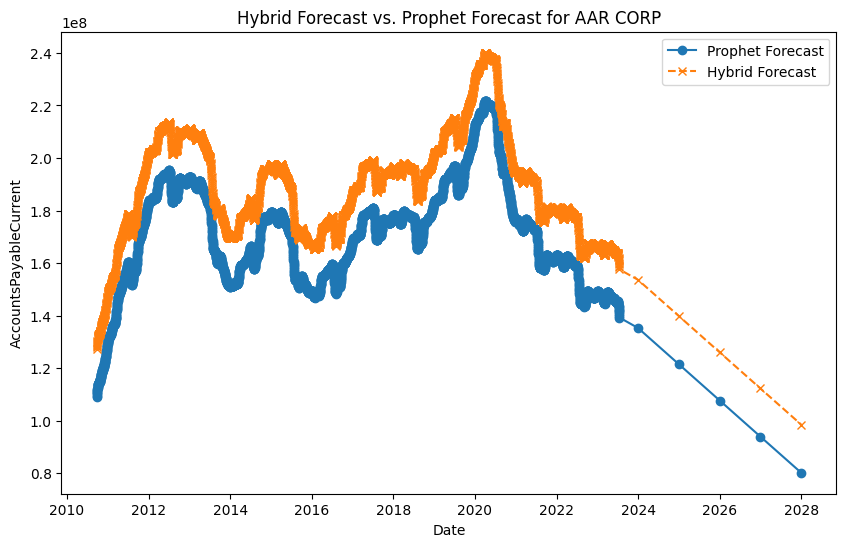

Hybrid Forecast Performance on Test Set:
MSE: 1233553121849.50
RMSE: 1110654.37
MAE: 1063014.79
MAPE: 0.67%

Base Prophet Forecast Performance on Test Set:
MSE: 319027960043109.62
RMSE: 17861353.81
MAE: 17858454.79
MAPE: 11.34%


In [33]:
# ---------------------------
# 1. Train XGBoost on Residuals
# ---------------------------
from xgboost import XGBRegressor

# Define features (lag1) and target (residual) for residual modeling
X_train = residual_data[['lag1']]
y_train = residual_data['residual']

# Initialize and train the XGBoost regressor
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
print("XGBoost model trained on residuals.")

# ---------------------------
# 2. Create Future Forecast with Prophet and Hybrid Model
# ---------------------------
# Create a future dataframe for the next 5 years (yearly frequency)
future = model.make_future_dataframe(periods=5, freq='Y')
future_forecast = model.predict(future)
future['yhat'] = future_forecast['yhat']

# For the residual model, generate a lag feature.
# Here, we use the last observed residual from forecast_df as a baseline.
last_residual = forecast_df['residual'].iloc[-1]
future['lag1'] = last_residual  # (Naively applying the same value for all future points)

# Predict residual corrections using the trained XGBoost model
future['residual_pred'] = xgb_model.predict(future[['lag1']])

# Combine Prophet forecast with the predicted residual correction
future['hybrid_forecast'] = future['yhat'] + future['residual_pred']

print("Hybrid forecast for future periods:")
print(future[['ds', 'yhat', 'residual_pred', 'hybrid_forecast']].tail())

# ---------------------------
# 3. Plot Forecasts
# ---------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(future['ds'], future['yhat'], label='Prophet Forecast', marker='o')
plt.plot(future['ds'], future['hybrid_forecast'], label='Hybrid Forecast', linestyle='--', marker='x')
plt.xlabel('Date')
plt.ylabel('AccountsPayableCurrent')
plt.title('Hybrid Forecast vs. Prophet Forecast for AAR CORP')
plt.legend()
plt.show()

# ---------------------------
# 4. Evaluate Forecast Performance on Test Set
# ---------------------------
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def calculate_metrics(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    # Avoid division by zero in MAPE calculation
    mape = np.mean(np.abs((actual - predicted) / (actual + 1e-8)))
    return mse, rmse, mae, mape

# For demonstration, define a small test set using the last 2 rows from forecast_df.
# In practice, use a larger holdout period.
test_df = forecast_df.tail(2).copy()

# Predict the residual correction for the test set using the XGBoost model
test_df['residual_pred'] = xgb_model.predict(test_df[['lag1']])
# Compute the hybrid forecast: Prophet's prediction plus the residual correction
test_df['hybrid_forecast'] = test_df['yhat'] + test_df['residual_pred']

# Calculate performance metrics comparing the hybrid forecast to the actual values
mse_val, rmse_val, mae_val, mape_val = calculate_metrics(test_df['y'], test_df['hybrid_forecast'])
print("Hybrid Forecast Performance on Test Set:")
print(f"MSE: {mse_val:.2f}")
print(f"RMSE: {rmse_val:.2f}")
print(f"MAE: {mae_val:.2f}")
print(f"MAPE: {mape_val:.2%}")

# Compare with base Prophet forecast performance on the same test set
base_mse, base_rmse, base_mae, base_mape = calculate_metrics(test_df['y'], test_df['yhat'])
print("\nBase Prophet Forecast Performance on Test Set:")
print(f"MSE: {base_mse:.2f}")
print(f"RMSE: {base_rmse:.2f}")
print(f"MAE: {base_mae:.2f}")
print(f"MAPE: {base_mape:.2%}")


In [34]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Use the daily aggregated data (agg_daily_df) directly
# Make sure the 'date' column is in datetime format and sorted
agg_daily_df['date'] = pd.to_datetime(agg_daily_df['date'], errors='coerce')
company_data = agg_daily_df.sort_values('date').copy()

# We'll use the AccountsPayableCurrent column as our time series (convert to numpy array)
values = company_data['AccountsPayableCurrent'].values.reshape(-1, 1)

# Scale the data to [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(values)

# Define a function to create sequences using 'n_steps' past values to predict the next value
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps])
    return np.array(X), np.array(y)

# Set number of time steps (e.g., use the past 3 days)
n_steps = 3
X, y = create_sequences(scaled_values, n_steps)

print("Shape of X:", X.shape)  # Expected shape: (samples, n_steps, 1)
print("Shape of y:", y.shape)


Shape of X: (4679, 3, 1)
Shape of y: (4679, 1)


In [35]:
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)


Training set shape: (3743, 3, 1) (3743, 1)
Test set shape: (936, 3, 1) (936, 1)


## Using deep learning techniques,starting with LSTM

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0676 - val_loss: 4.6526e-04
Epoch 2/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.7667e-04 - val_loss: 3.9848e-04
Epoch 3/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.5932e-04 - val_loss: 3.8605e-04
Epoch 4/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5804e-04 - val_loss: 3.7861e-04
Epoch 5/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5659e-04 - val_loss: 3.7268e-04
Epoch 6/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5463e-04 - val_loss: 3.6627e-04
Epoch 7/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.4993e-04 - val_loss: 3.6204e-04
Epoch 8/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.4596e-04 - val_loss: 3.5865e-04
Epoch 9/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4230e-04 - val_loss: 3.5468e-04
Epoch 10/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3934e-04 - val_loss: 3.4923e-04
Epoch 11/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

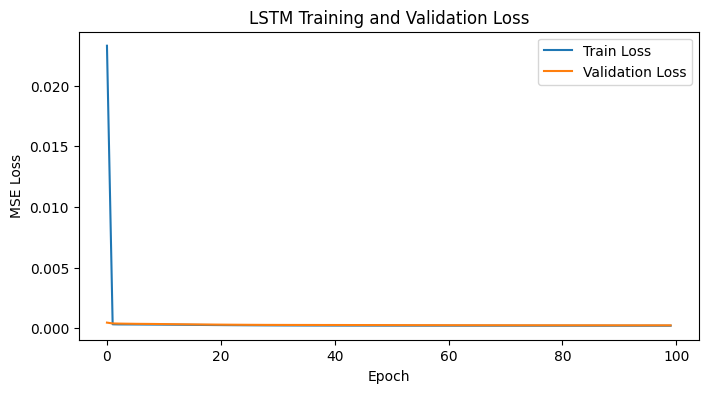

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step 
LSTM Forecast Performance on Test Set:
MSE: 3414170886862.15
RMSE: 1847747.52
MAE: 461920.64


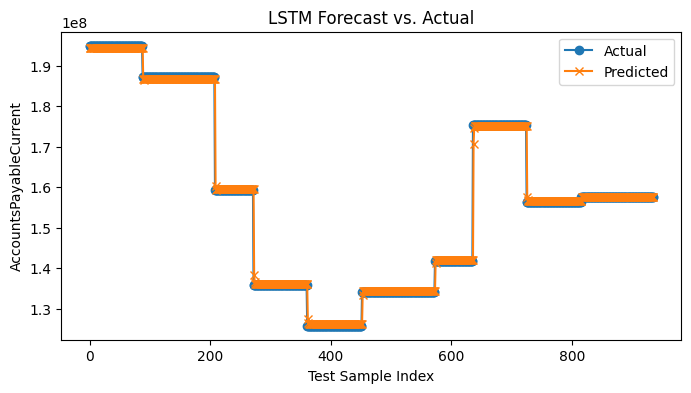

In [36]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Build the LSTM model
model_lstm = Sequential([
    LSTM(50, activation='relu', input_shape=(n_steps, 1)),
    Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.summary()

# Train the model
history = model_lstm.fit(X_train, y_train, epochs=100, batch_size=16,
                          validation_data=(X_test, y_test), verbose=1)

# Plot training and validation loss over epochs
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("LSTM Training and Validation Loss")
plt.show()

# Predict on the test set
y_pred_scaled = model_lstm.predict(X_test)

# Invert the scaling to get actual values
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test)

# Evaluate performance using common metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

mse_lstm = mean_squared_error(y_test_actual, y_pred)
rmse_lstm = np.sqrt(mse_lstm)
mae_lstm = mean_absolute_error(y_test_actual, y_pred)

print("LSTM Forecast Performance on Test Set:")
print(f"MSE: {mse_lstm:.2f}")
print(f"RMSE: {rmse_lstm:.2f}")
print(f"MAE: {mae_lstm:.2f}")

# Plot actual vs. predicted values for the test set
plt.figure(figsize=(8, 4))
plt.plot(y_test_actual, marker='o', label='Actual')
plt.plot(y_pred, marker='x', label='Predicted')
plt.title("LSTM Forecast vs. Actual")
plt.xlabel("Test Sample Index")
plt.ylabel("AccountsPayableCurrent")
plt.legend()
plt.show()


## Now using transformers,which can capture more patterns in general than LSTM

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Define Positional Encoding module
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)  # (max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # (max_len, 1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)  # even indices
        pe[:, 1::2] = torch.cos(position * div_term)  # odd indices
        pe = pe.unsqueeze(1)  # (max_len, 1, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x shape: (seq_length, batch_size, d_model)
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

# Define the Transformer model for time series forecasting
class TimeSeriesTransformer(nn.Module):
    def __init__(self, feature_size=1, num_layers=2, nhead=2, dim_feedforward=64, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()
        self.input_projection = nn.Linear(feature_size, dim_feedforward)
        self.pos_encoder = PositionalEncoding(dim_feedforward, dropout)
        encoder_layer = nn.TransformerEncoderLayer(d_model=dim_feedforward, nhead=nhead, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(dim_feedforward, 1)  # Output single value

    def forward(self, src):
        # src shape: (seq_length, batch_size, feature_size)
        src = self.input_projection(src)          # (seq_length, batch_size, dim_feedforward)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)      # (seq_length, batch_size, dim_feedforward)
        # Use the output of the last time step for forecasting
        out = self.decoder(output[-1, :, :])        # (batch_size, 1)
        return out

# Assuming you already created sequences X and y from your daily aggregated data.
# X should have shape (samples, n_steps, 1), and y shape (samples, 1).

# For transformer, we need shape: (seq_length, batch_size, feature_size)
# Here we convert the numpy arrays to PyTorch tensors and transpose accordingly:
X_tensor = torch.tensor(X, dtype=torch.float32)  # shape: (samples, n_steps, 1)
y_tensor = torch.tensor(y, dtype=torch.float32)  # shape: (samples, 1)
X_tensor = X_tensor.transpose(0, 1)  # Now shape: (n_steps, samples, 1)

# Instantiate the model
model_trans = TimeSeriesTransformer(feature_size=1, num_layers=2, nhead=2, dim_feedforward=64, dropout=0.1)
print(model_trans)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model_trans.parameters(), lr=0.001)

# Training loop (for demonstration, we train for 100 epochs using the entire dataset as a single batch)
num_epochs = 100
for epoch in range(num_epochs):
    model_trans.train()
    optimizer.zero_grad()
    # Forward pass: predict the next value using the transformer model
    output = model_trans(X_tensor)  # output shape: (samples, 1)
    loss = criterion(output, y_tensor)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

# Example prediction: Predict on the training set itself (for demonstration)
model_trans.eval()
with torch.no_grad():
    predictions = model_trans(X_tensor)
    
# Convert predictions back to numpy
predictions = predictions.numpy()
y_actual = y_tensor.numpy()

# Print sample predictions
print("Sample predictions:")
for i in range(5):
    print(f"Predicted: {predictions[i][0]:.4f}, Actual: {y_actual[i][0]:.4f}")


enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)


TimeSeriesTransformer(
  (input_projection): Linear(in_features=1, out_features=64, bias=True)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): Linear(in_features=64, out_features=1, bias=True)
)
Epoch 10/100, Loss: 0.2821
Epoch 20/100, 

Training set shape: (3743, 3, 1) (3743, 1)
Test set shape: (936, 3, 1) (936, 1)
Transformer Model Forecast Performance on Test Set:
MSE: 0.00
RMSE: 0.03
MAE: 0.02
MAPE: 13.78%


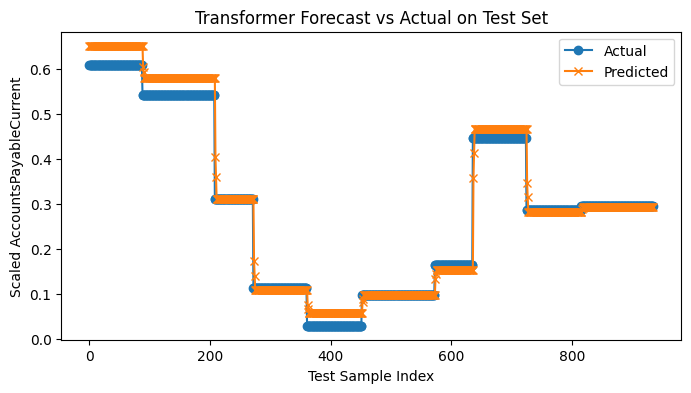

In [39]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import torch
import matplotlib.pyplot as plt

# Split the data: 80% for training, 20% for testing
split_idx = int(0.8 * X.shape[0])
X_train = X[:split_idx]  # shape: (train_samples, n_steps, 1)
y_train = y[:split_idx]  # shape: (train_samples, 1)
X_test = X[split_idx:]   # shape: (test_samples, n_steps, 1)
y_test = y[split_idx:]   # shape: (test_samples, 1)

print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

# Convert test set sequences to PyTorch tensors and transpose them
# Transformer expects input of shape: (seq_length, batch_size, feature_size)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).transpose(0, 1)  # shape: (n_steps, test_samples, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Evaluate the transformer model on the test set
model_trans.eval()
with torch.no_grad():
    y_pred_test = model_trans(X_test_tensor)  # predicted shape: (test_samples, 1)
    
# Convert predictions and actual values to numpy arrays
y_pred_test = y_pred_test.numpy()
y_test_actual = y_test_tensor.numpy()

# Calculate evaluation metrics
mse_transformer = mean_squared_error(y_test_actual, y_pred_test)
rmse_transformer = np.sqrt(mse_transformer)
mae_transformer = mean_absolute_error(y_test_actual, y_pred_test)
mape_transformer = np.mean(np.abs((y_test_actual - y_pred_test) / (y_test_actual + 1e-8)))

print("Transformer Model Forecast Performance on Test Set:")
print(f"MSE: {mse_transformer:.2f}")
print(f"RMSE: {rmse_transformer:.2f}")
print(f"MAE: {mae_transformer:.2f}")
print(f"MAPE: {mape_transformer:.2%}")

# Optionally, plot the predicted vs. actual values for a visual comparison
plt.figure(figsize=(8, 4))
plt.plot(y_test_actual, marker='o', label='Actual')
plt.plot(y_pred_test, marker='x', label='Predicted')
plt.xlabel('Test Sample Index')
plt.ylabel('Scaled AccountsPayableCurrent')
plt.title('Transformer Forecast vs Actual on Test Set')
plt.legend()
plt.show()


In [40]:
# Assuming `scaler` was fitted on the original values:
y_pred_original = scaler.inverse_transform(y_pred_test)
y_test_original = scaler.inverse_transform(y_test_actual)

mse_orig = mean_squared_error(y_test_original, y_pred_original)
rmse_orig = np.sqrt(mse_orig)
mae_orig = mean_absolute_error(y_test_original, y_pred_original)
mape_orig = np.mean(np.abs((y_test_original - y_pred_original) / (y_test_original + 1e-8)))

print("Transformer Model Forecast Performance on Test Set (Original Scale):")
print(f"MSE: {mse_orig:.2f}")
print(f"RMSE: {rmse_orig:.2f}")
print(f"MAE: {mae_orig:.2f}")
print(f"MAPE: {mape_orig:.2%}")


Transformer Model Forecast Performance on Test Set (Original Scale):
MSE: 11085560152064.00
RMSE: 3329498.50
MAE: 2041836.12
MAPE: 1.23%
